In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from statsmodels.tsa.ar_model import AutoReg

# Prophet libs
import prophet

# Sklearn libs
from sklearn.metrics import mean_squared_error as mse

## 1. Loading data

In [17]:
# Fixing csv file
with open("data/air_quality_sensor_data.csv", "r") as f:
    text = ''.join([i for i in f]).replace(";", ",")

with open("data/air_quality_sensor_data.csv", "w") as f:
    f.writelines(text)

In [18]:
# Loading data
data = pd.read_csv("data/air_quality_sensor_data.csv")
print(data.shape)
data.head()

(360, 4)


,Timestamp,PM1,PM10,PM25
0,2021-11-11 14:04:03,10,36.016907,29.994762
1,2021-11-11 16:04:03,10,39.262622,29.965451
2,2021-11-11 18:04:03,10,40.017659,29.963461
3,2021-11-11 20:04:03,10,43.428453,29.999926
4,2021-11-11 22:04:03,10,44.946480,29.992089


In [19]:
def prep_data(df, model_type):
    # Removing unnecessary data (Only predicting PM10)
    df = df.drop(["PM1", "PM25"], axis=1)
    # Renaming Timestamp column ds and PM10 to y 
    df.rename(columns={'Timestamp':'ds'}, inplace=True)
    df.rename(columns={'PM10':'y'}, inplace=True)
    # Creating test and train datasets
    if model_type == "AR":
        X = differ(df.values)
        size = int(len(X) * 0.66)
        ar_train, ar_test = X[0:size], X[size:]
        return df, ar_train, ar_test
    elif model_type == "Prophet":
        size = int(len(df) * 0.66)
        prophet_train, prophet_test = df[0:size], df[size:]
        return df, prophet_train, prophet_test

df, prophet_train, prophet_test = prep_data(data, model_type="Prophet")

print(f"Df Shape: {df.shape}")
print(f"Train Shape: {prophet_train.shape}")
print(f"Test Shape: {prophet_test.shape}")
df.head()

Df Shape: (360, 2)
Train Shape: (237, 2)
Test Shape: (123, 2)


,ds,y
0,2021-11-11 14:04:03,36.016907
1,2021-11-11 16:04:03,39.262622
2,2021-11-11 18:04:03,40.017659
3,2021-11-11 20:04:03,43.428453
4,2021-11-11 22:04:03,44.946480


In [20]:
df.describe()

,y
count,360.000000
mean,45.060716
std,9.946582
min,31.062247
25%,36.863576
50%,41.113733
75%,56.199117
max,60.000000


<AxesSubplot:>

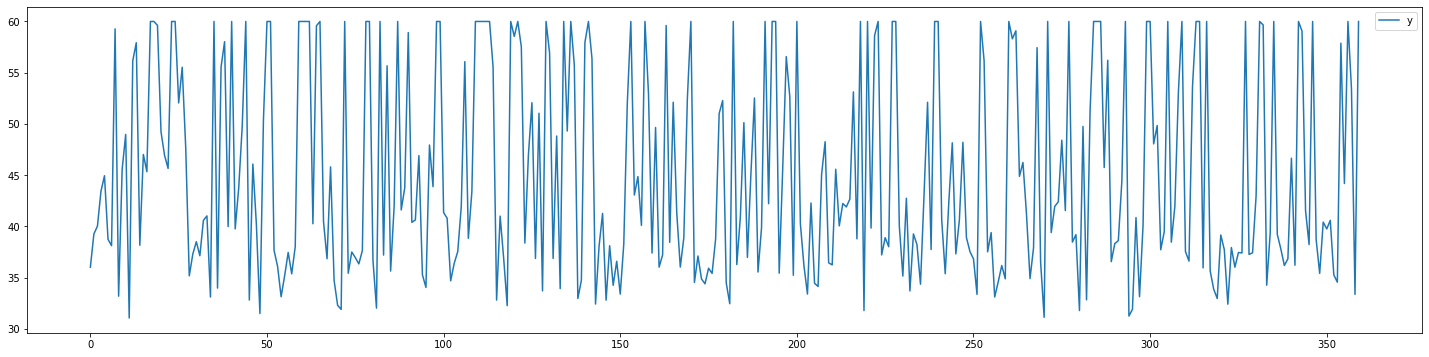

In [21]:
# Plotting data
plt.rcParams['figure.figsize'] = [25, 6]
df.plot()

## 2. Prophet Model

#### 2.1 Building Prophet Model

In [22]:
# Training Models
m = prophet.Prophet(yearly_seasonality=False)
pro_model = m.fit(prophet_train)

Initial log joint probability = -6.57597


/home/irayb/miniconda3/envs/aq_pred/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       318.823   2.65083e-06       98.9378           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       318.823   6.13849e-09       87.4422       0.383       0.383      154   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [23]:
# Predicting future values
future = pro_model.make_future_dataframe(periods=15)
forecast = pro_model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

/home/irayb/miniconda3/envs/aq_pred/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/irayb/miniconda3/envs/aq_pred/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
247,2021-12-12 06:04:03,42.644964,30.716062,55.083851
248,2021-12-13 06:04:03,41.768283,28.728705,54.675735
249,2021-12-14 06:04:03,42.911723,31.333385,55.020512
250,2021-12-15 06:04:03,38.951221,26.476375,51.432893
251,2021-12-16 06:04:03,40.306771,28.679149,52.510759


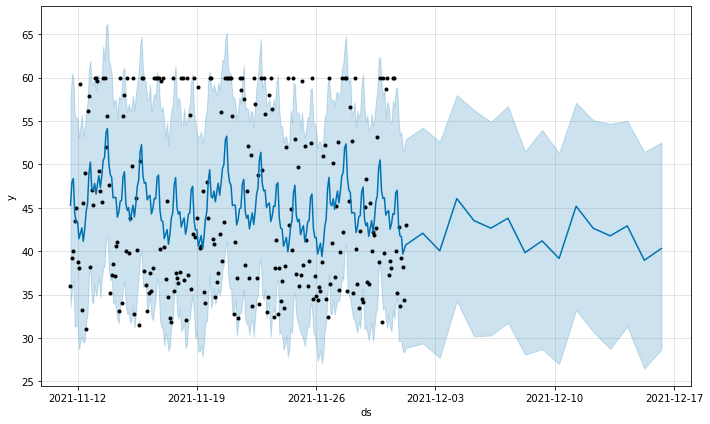

In [24]:
# Ploting forecast
fig1 = pro_model.plot(forecast)

/home/irayb/miniconda3/envs/aq_pred/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/irayb/miniconda3/envs/aq_pred/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


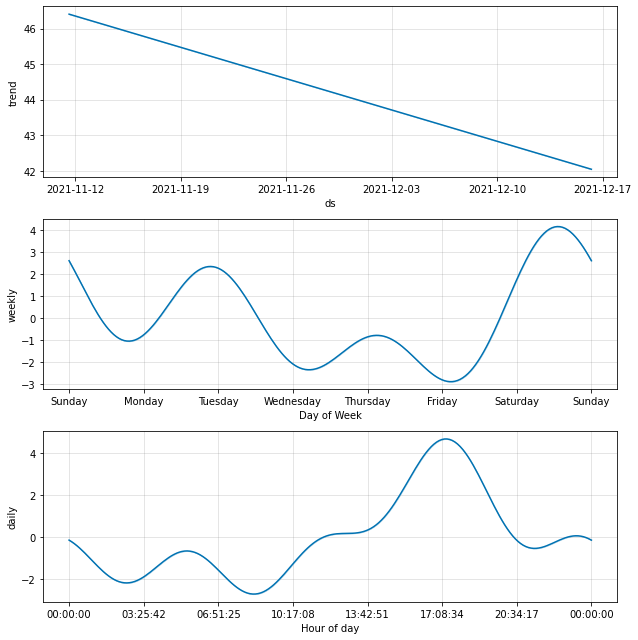

In [25]:
fig2 = pro_model.plot_components(forecast)

## 3. Building AR Model

In [26]:
# Creating Difference Transform function
def differ(df):
    diff = []
    for t in range(1, len(df)):
        val = df[t] - df[t-1]
        diff.append(val)
    return np.array(diff)

In [27]:
# Making prediction 
def predict(coef, hist):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * hist[-i]
    return yhat

In [28]:
# Importing data for AR model
data = pd.read_csv("data/air_quality_sensor_data.csv", header=0, index_col=0, parse_dates=True, squeeze=True)

df, ar_train, ar_test = prep_data(data, model_type="AR")

print(f"Df Shape: {df.shape}")
print(f"Train Shape: {ar_train.shape}")
print(f"Test Shape: {ar_test.shape}")
df.head()

Df Shape: (360, 1)
Train Shape: (236, 1)
Test Shape: (123, 1)


/tmp/ipykernel_13102/1601624502.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv("data/air_quality_sensor_data.csv", header=0, index_col=0, parse_dates=True, squeeze=True)


,y
Timestamp,
2021-11-11 14:04:03,36.016907
2021-11-11 16:04:03,39.262622
2021-11-11 18:04:03,40.017659
2021-11-11 20:04:03,43.428453
2021-11-11 22:04:03,44.946480


In [29]:
# Train AR model
ar_model = AutoReg(ar_train, lags=6)
ar_model_fit = ar_model.fit()
coef = ar_model_fit.params

In [31]:
# Predicting test 
history = [ar_train[i] for i in range(len(ar_train))]
pred = []

for t in range(len(ar_test)):
	yhat = predict(coef, history)
	obs = ar_test[t]
	pred.append(yhat)
	history.append(obs)

ar_rmse = sqrt(mse(ar_test, pred))
print(f"AR Model RMSE: {ar_rmse}")

AR Model RMSE: 11.010765688000955
